In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import time
from torchvision import datasets

In [2]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5,), (0.5,))]
)

In [3]:
# get the data
trainset = datasets.MNIST(
    root = 'data',
    train = True,
    download = True, 
    transform = transform
)
trainloader = torch.utils.data.DataLoader(
    trainset, 
    batch_size = 4,
    shuffle = True
)
testset = datasets.MNIST(
    root = 'data',
    train = False,
    download = True,
    transform = transform
)
testloader = torch.utils.data.DataLoader(
    testset, 
    batch_size = 4,
    shuffle = False
)

torch.Size([4, 1, 28, 28])
tensor([5, 2, 4, 6])


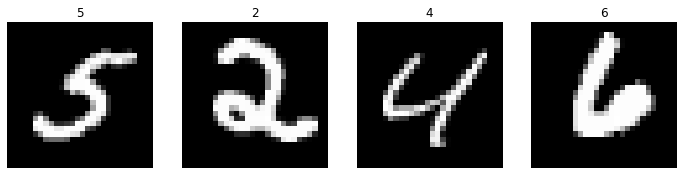

In [4]:
for batch_1 in trainloader:
    batch = batch_1
    break
print(batch[0].shape) # as batch[0] contains the image pixels -> tensors
print(batch[1]) # batch[1] contains the labels -> tensors
plt.figure(figsize=(12, 8))
for i in range (batch[0].shape[0]):
    plt.subplot(1, 4, i+1)
    plt.axis('off')
    plt.imshow(batch[0][i].reshape(28, 28), cmap='gray')
    plt.title(int(batch[1][i]))
    plt.savefig('digit_mnist.png')
plt.show()

In [5]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=20, 
                               kernel_size=5, stride=1)
        self.conv2 = nn.Conv2d(in_channels=20, out_channels=50, 
                               kernel_size=5, stride=1)
        self.fc1 = nn.Linear(in_features=800, out_features=500)
        self.fc2 = nn.Linear(in_features=500, out_features=10)
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [6]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [7]:
net = Net().to(device)
print(net)

Net(
  (conv1): Conv2d(1, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(20, 50, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=800, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=10, bias=True)
)


In [8]:
# loss function
criterion = nn.CrossEntropyLoss()
# optimizer
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [9]:
def train(net):
    start = time.time()
    for epoch in range(10): # no. of epochs
        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            # data pixels and labels to GPU if available
            inputs, labels = data[0].to(device, non_blocking=True), data[1].to(device, non_blocking=True)
            # set the parameter gradients to zero
            optimizer.zero_grad()
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            # propagate the loss backward
            loss.backward()
            optimizer.step()
            # print for mini batches
            running_loss += loss.item()
            if i % 5000 == 4999:  # every 5000 mini batches
                print('[Epoch %d, %5d Mini Batches] loss: %.3f' %
                      (epoch + 1, i + 1, running_loss/5000))
                running_loss = 0.0
    end = time.time()
    print('Done Training')
    print('%0.2f minutes' %((end - start) / 60))
    
train(net)

[Epoch 1,  5000 Mini Batches] loss: 0.301
[Epoch 1, 10000 Mini Batches] loss: 0.083
[Epoch 1, 15000 Mini Batches] loss: 0.061
[Epoch 2,  5000 Mini Batches] loss: 0.046
[Epoch 2, 10000 Mini Batches] loss: 0.043
[Epoch 2, 15000 Mini Batches] loss: 0.038
[Epoch 3,  5000 Mini Batches] loss: 0.027
[Epoch 3, 10000 Mini Batches] loss: 0.029
[Epoch 3, 15000 Mini Batches] loss: 0.026
[Epoch 4,  5000 Mini Batches] loss: 0.021
[Epoch 4, 10000 Mini Batches] loss: 0.017
[Epoch 4, 15000 Mini Batches] loss: 0.021
[Epoch 5,  5000 Mini Batches] loss: 0.011
[Epoch 5, 10000 Mini Batches] loss: 0.017
[Epoch 5, 15000 Mini Batches] loss: 0.015
[Epoch 6,  5000 Mini Batches] loss: 0.009
[Epoch 6, 10000 Mini Batches] loss: 0.014
[Epoch 6, 15000 Mini Batches] loss: 0.012
[Epoch 7,  5000 Mini Batches] loss: 0.009
[Epoch 7, 10000 Mini Batches] loss: 0.008
[Epoch 7, 15000 Mini Batches] loss: 0.010
[Epoch 8,  5000 Mini Batches] loss: 0.007
[Epoch 8, 10000 Mini Batches] loss: 0.006
[Epoch 8, 15000 Mini Batches] loss

In [10]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        inputs, labels = data[0].to(device, non_blocking=True), data[1].to(device, non_blocking=True)
        outputs = net(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
print('Accuracy of the network on test images: %0.3f %%' % (
    100 * correct / total))

Accuracy of the network on test images: 99.280 %
